# Netflix-Sentiment-Classification-Two

# Imports

In [42]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Functions

In [37]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df, y, axis):
  fig, ax = plt.subplots(figsize=(15, 8))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Models")
  ax.set_ylabel("Accuracy")
  plt.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()
  
def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  
  filtered_word_tokens = re.sub(f"[^a-zA-z\s]", "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "KNN": SMOTE(k_neighbors=5),
    "ADASYN": ADASYN()
  }
  
  return [models[model_name] for model_name in model_names]

def create_sampling_pipeline(sampling_model, model):
  steps = [
    ("sample", sampling_model),
    ("model", model)
  ]
  return imbPipeline(steps=steps)

def evaluate_model(X, y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model,X, y, cv=cv, scoring=metric, n_jobs=-1)
  return scores

def tested_selected_models(model_names, models, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    scores = evaluate_model(X, y, model)
    model_performance.append({
      "Model":model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def test_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y):
  
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      scores = evaluate_model(X, y, pipeline)
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD"], "Mean")
  print(performance_df)

def create_train_test_splits(X, y):
  
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  return X_train, X_test, X_val, y_val, y_train, y_test

def test_predictions(sampling_model_names, sampling_models, model_names, models, X, y, params=None):
  
  X_train, X_test, X_val, y_val, y_train, y_test = create_train_test_splits(X, y)
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      
      X_train_sampled, y_train_sampled = sample_model.fit_resample(X_train, y_train)
      if params is not None:
        grid_search = GridSearchCV(model, params[model_name],cv=5, n_jobs=-1, scoring=make_scorer(f1_score))
        grid_search.fit(X_train_sampled, y_train_sampled)
        
      else:
        model.fit(X_train_sampled, y_train_sampled)
    
      val_pred = model.predict(X_val)
      test_pred =model.predict(X_test)
      
      val_acc = accuracy_score(val_pred, y_val)
      test_acc = accuracy_score(test_pred, y_test)
      
      val_f1_score = f1_score(val_pred, y_val, average="micro")
      test_f1_score = f1_score(test_pred, y_test, average="micro")
      
      model_performance.append({
        "Model": model_name + "-" + sample_model_name,
        "Test-F1-Score": test_f1_score,
        "Val-F1-Score": val_f1_score,
        "Test-Acc": test_acc,
        "Val-Acc": val_acc
      })
      
      del X_train_sampled
      del y_train_sampled
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test-F1-Score", ascending=False).reset_index()
  plot_model_performance(
    model_performance_df,
    ["Test-F1-Score", "Val-F1-Score","Test-Acc", "Val-Acc"], 
    "Metrics"
    )
  print(model_performance_df)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/netflix_reviews.csv",nrows=5500)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1772b40f-8cfd-4c56-a370-c944e5b5ce48,Gato Reviews,Utter trash. Been a customer for over 10 years...,1,0,8.114.0 build 19 50680,2024-05-23 22:35:45,8.114.0 build 19 50680
1,b6b64d5c-30f6-4bed-8d66-9b4582e72e3b,Quincy Alleyne,Good,5,0,8.115.2 build 6 50688,2024-05-23 22:34:47,8.115.2 build 6 50688
2,8be7d06b-f90e-4ca7-abf6-f908b40946e2,nez zuber,The only streaming service that beats Netflix ...,2,0,NaN,2024-05-23 22:33:52,NaN
3,72485684-9e73-4dca-a580-0a92b3a3a7e6,Elon Frett,Everything that's objectively good gets remove...,1,0,8.109.0 build 7 50647,2024-05-23 22:30:43,8.109.0 build 7 50647
4,348796c3-0056-4491-80f7-d6c38fcb2790,kwakhanya bambeni,Wish the owner be a trillioner because he/she ...,4,0,NaN,2024-05-23 22:30:27,NaN
...,...,...,...,...,...,...,...,...
5495,7d907c38-8713-4f2c-85eb-6d221d72087e,Nandni Jotwani,I cannot use my family account just because I ...,1,1,8.105.0 build 15 50626,2024-03-09 06:10:54,8.105.0 build 15 50626
5496,9b357bc2-3f03-48e3-8e60-163d54c8bd24,Stan Waltman,They keep removing shows and movies. I feel li...,3,1,8.109.0 build 7 50647,2024-04-11 08:12:27,8.109.0 build 7 50647
5497,487bcb0b-cba0-4132-93a7-735d19ca139b,Mark Townsend,Why take away the brilliant widget on android....,3,0,8.107.0 build 9 50640,2024-03-25 19:29:21,8.107.0 build 9 50640
5498,b4b7478a-d1bf-4c58-a010-be0e65536a3e,Hasan Erman TARAKCI,Fails playing (or validating) downloaded video...,2,4,8.96.1 build 16 50568,2024-01-06 00:25:00,8.96.1 build 16 50568


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                  0
userName                  0
content                   2
score                     0
thumbsUpCount             0
reviewCreatedVersion    625
at                        0
appVersion              625
dtype: int64
The amount of Duplicated values: 287


In [5]:
df.dropna(inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(4648, 8)

# Check for Class Imabalance

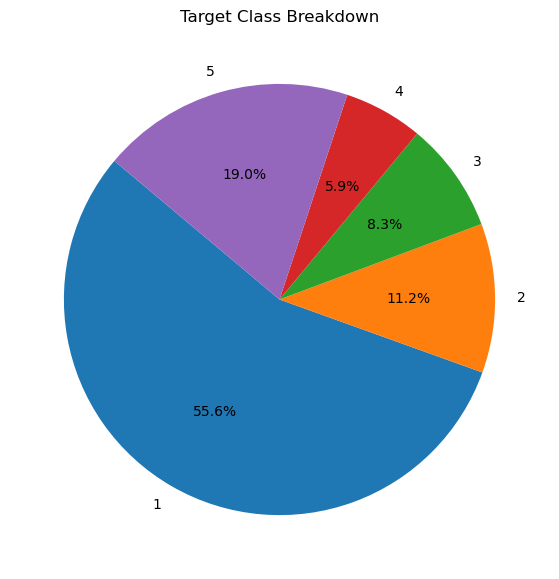

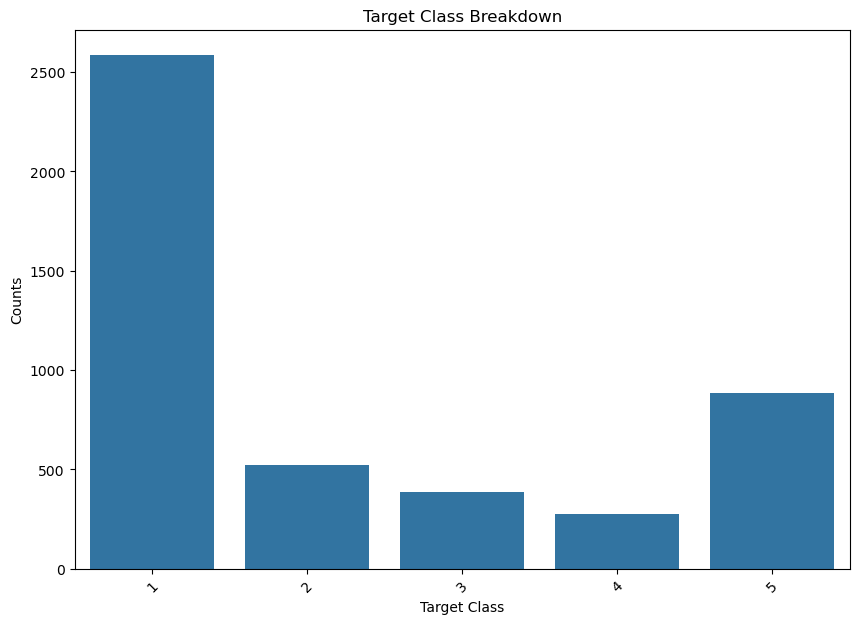

In [8]:
check_class_imbalance(df["score"])

# Skewed Dataset

# Drop Columns we do not need

In [9]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

# Data Preprocessing

In [10]:

df["content"] = df["content"].apply(lambda x: remove_stop_words(x))
df["score"] = df["score"].apply(lambda x: "postive" if x>=4 else "neg" if x<3 else "neu")
df["at"] = pd.to_datetime(df["at"])

df["day"] = df["at"].dt.day
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year
df["hour"] = df["at"].dt.hour

df.drop("at", axis=1, inplace=True)

# Separate Feature Variables

In [11]:
X, y = df.drop("score", axis=1), df["score"]

# Label Encoder

In [12]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Create Pipeline

In [13]:
vectorizer = TfidfVectorizer(max_features=50)

tfidf_matrix = vectorizer.fit_transform(X["content"])

tfidf_transformed = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [14]:
tfidf_transformed.shape

(4648, 50)

In [15]:
X.drop("content", axis=1, inplace=True)

In [16]:
tfidf_transformed.index = X.index

X_tfidf = pd.concat([X, tfidf_transformed], axis=1)

In [17]:
pipeline = Pipeline(
  steps=[
    ("scaler", StandardScaler()),
    ("powertransformer", PowerTransformer())
  ]
)

X_processed = pipeline.fit_transform(X_tfidf)

In [18]:
X_processed.shape

(4648, 55)

# Baseline Model Performance

In [19]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X_processed, y_encoded, model)
print(f"Mean Accuracy-Score: {round(np.mean(scores),3)}, STD:{round(np.std(scores),3)}")

Mean Accuracy-Score: 0.333, STD:0.014


# Advanced Model Metrics

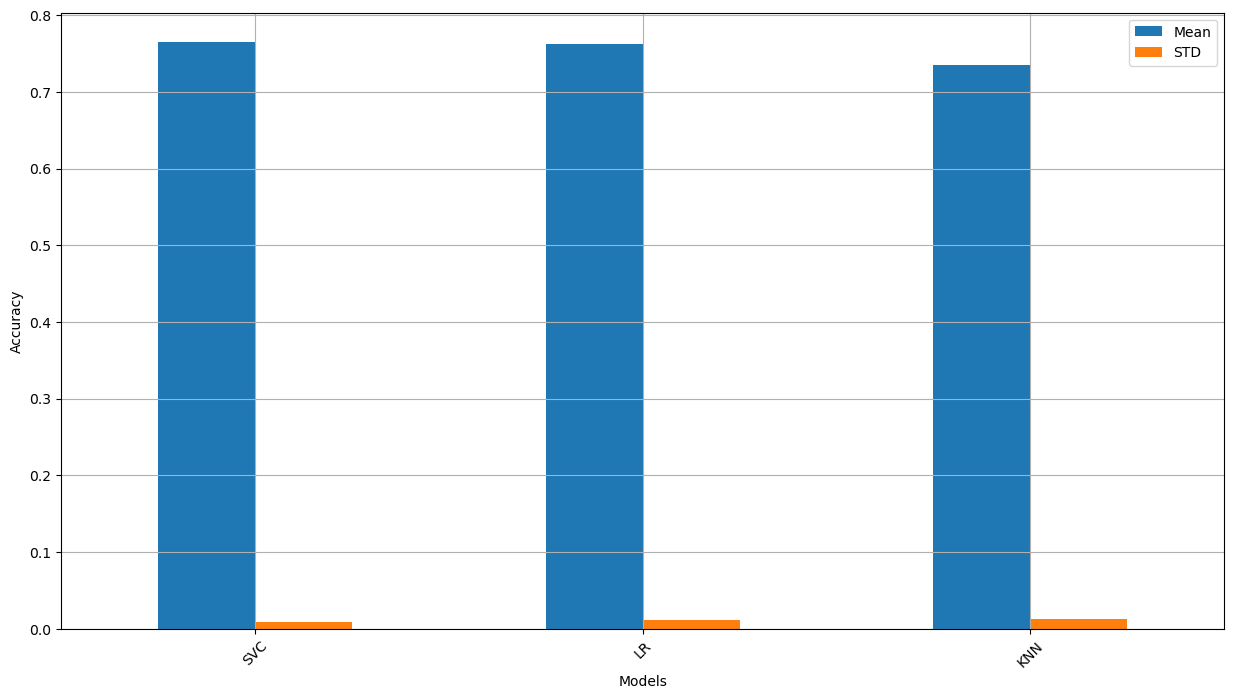

   index Model   Mean    STD
0      1   SVC  0.765  0.009
1      0    LR  0.763  0.011
2      2   KNN  0.735  0.012


In [20]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X_processed, y_encoded)


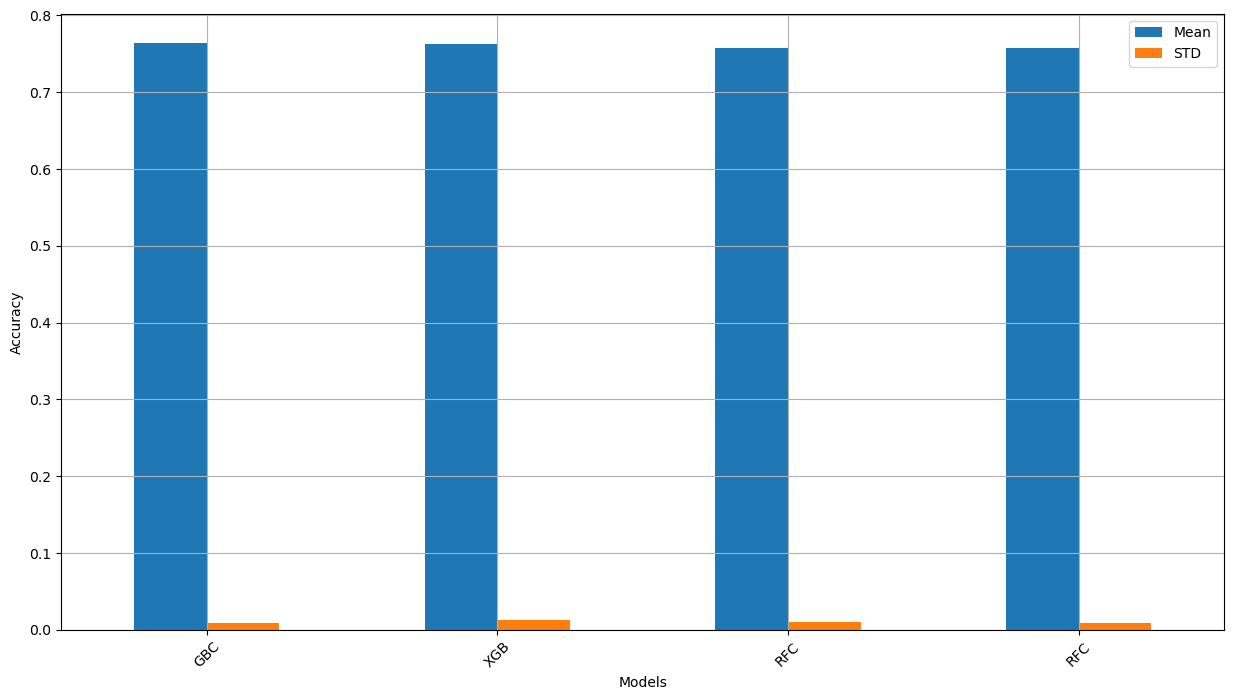

   index Model   Mean    STD
0      1   GBC  0.764  0.009
1      2   XGB  0.763  0.012
2      0   RFC  0.758  0.010
3      3   RFC  0.758  0.009


In [21]:
model_names = ["RFC", "GBC", "XGB", "RFC"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X_processed, y_encoded)

# Model Scores are poor due to the fact of class imbalance. Let's address this with some sampling models.

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


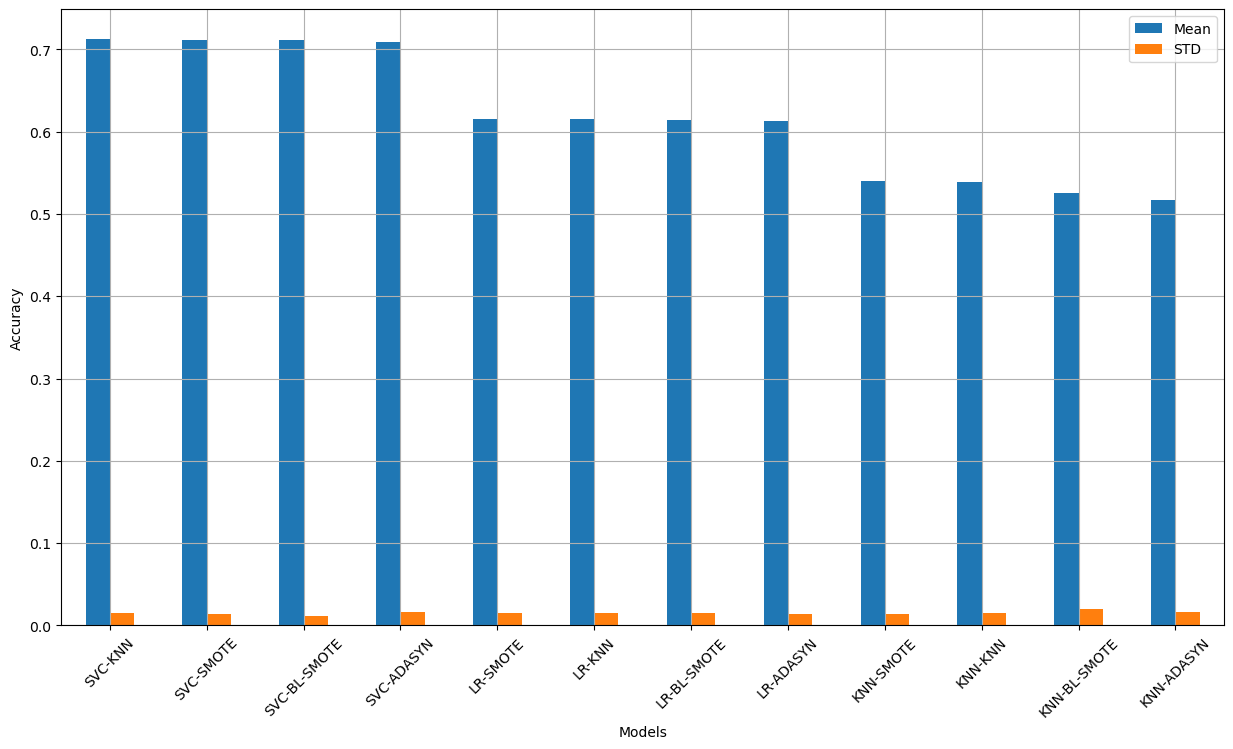

    index         Model   Mean    STD
0       3       SVC-KNN  0.713  0.015
1       0     SVC-SMOTE  0.712  0.014
2       6  SVC-BL-SMOTE  0.711  0.011
3       9    SVC-ADASYN  0.709  0.016
4       1      LR-SMOTE  0.616  0.015
5       4        LR-KNN  0.616  0.015
6       7   LR-BL-SMOTE  0.614  0.015
7      10     LR-ADASYN  0.613  0.014
8       2     KNN-SMOTE  0.540  0.014
9       5       KNN-KNN  0.539  0.015
10      8  KNN-BL-SMOTE  0.525  0.020
11     11    KNN-ADASYN  0.517  0.016


In [22]:
sampling_model_names = ["SMOTE", "KNN", "BL-SMOTE", "ADASYN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)

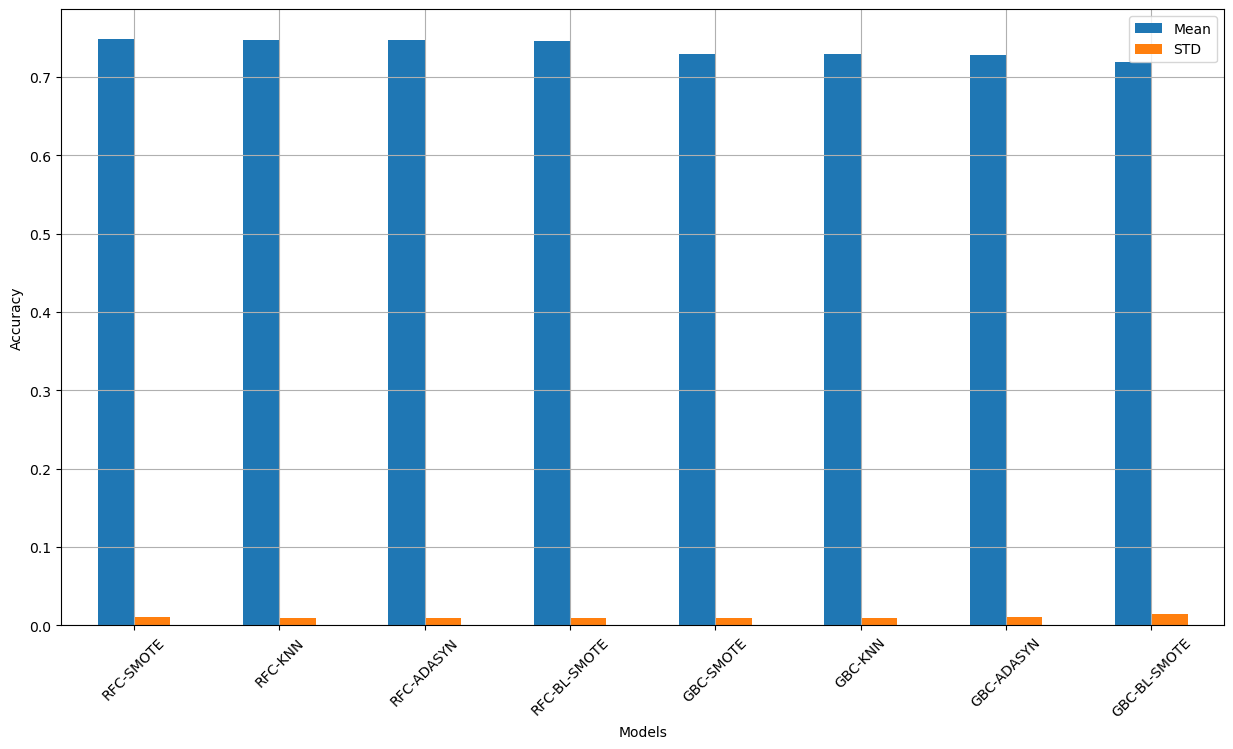

   index         Model   Mean    STD
0      0     RFC-SMOTE  0.749  0.011
1      2       RFC-KNN  0.748  0.010
2      6    RFC-ADASYN  0.747  0.009
3      4  RFC-BL-SMOTE  0.746  0.009
4      1     GBC-SMOTE  0.730  0.010
5      3       GBC-KNN  0.730  0.010
6      7    GBC-ADASYN  0.728  0.011
7      5  GBC-BL-SMOTE  0.719  0.014


In [23]:
model_names = ["RFC", "GBC"]
models = grab_selected_models(model_names)
test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)

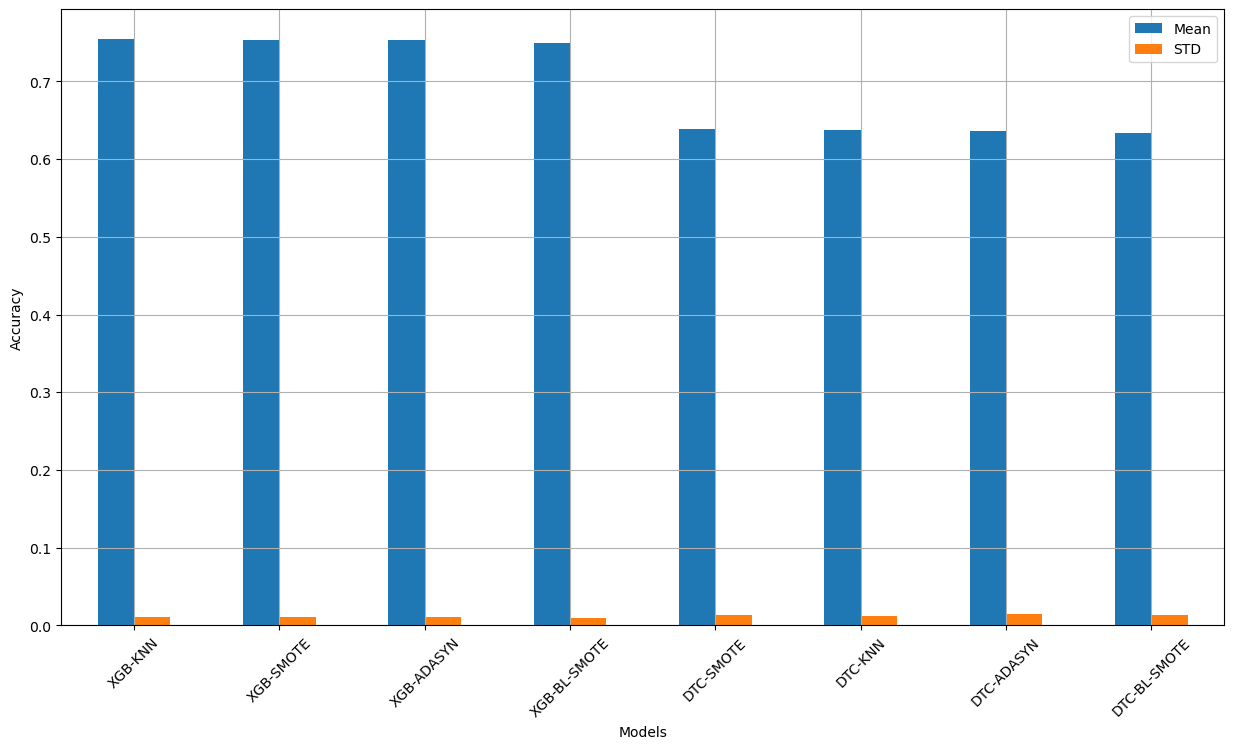

   index         Model   Mean    STD
0      2       XGB-KNN  0.755  0.011
1      0     XGB-SMOTE  0.754  0.011
2      6    XGB-ADASYN  0.753  0.011
3      4  XGB-BL-SMOTE  0.750  0.010
4      1     DTC-SMOTE  0.639  0.014
5      3       DTC-KNN  0.637  0.012
6      7    DTC-ADASYN  0.636  0.015
7      5  DTC-BL-SMOTE  0.634  0.013


In [24]:
sampling_model_names = ["SMOTE", "KNN", "BL-SMOTE", "ADASYN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

model_names = ["XGB", "DTC"]
models = grab_selected_models(model_names)
test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)

# Model is performing the same or worse even with over sampling methods. Due to extreme class imbalance. 

# Lets pick a sampling model and try running some predictions and reasses what our approach should be here.

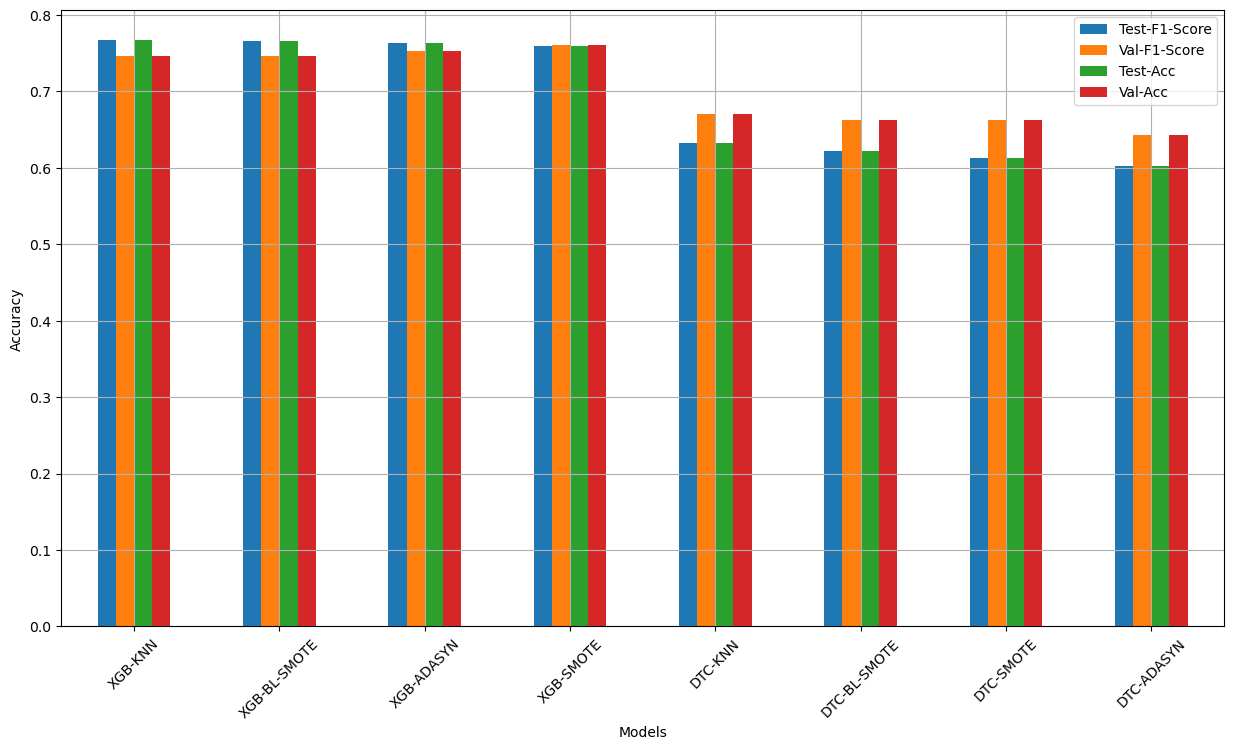

   index         Model  Test-F1-Score  Val-F1-Score  Test-Acc   Val-Acc
0      2       XGB-KNN       0.767742      0.746237  0.767742  0.746237
1      4  XGB-BL-SMOTE       0.765591      0.746237  0.765591  0.746237
2      6    XGB-ADASYN       0.763441      0.752688  0.763441  0.752688
3      0     XGB-SMOTE       0.759140      0.761290  0.759140  0.761290
4      3       DTC-KNN       0.632258      0.670968  0.632258  0.670968
5      5  DTC-BL-SMOTE       0.621505      0.662366  0.621505  0.662366
6      1     DTC-SMOTE       0.612903      0.662366  0.612903  0.662366
7      7    DTC-ADASYN       0.602151      0.643011  0.602151  0.643011


In [38]:
model_names = ["XGB", "DTC"]
models = grab_selected_models(model_names)

test_predictions(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)

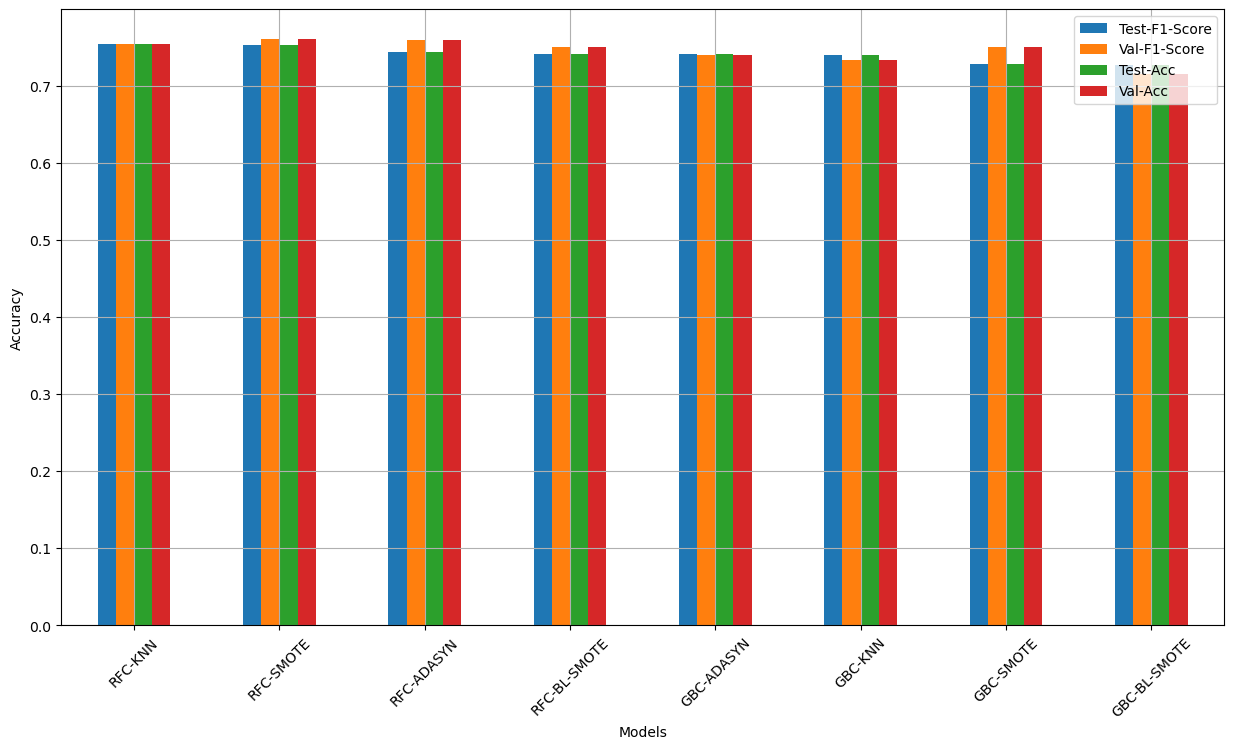

   index         Model  Test-F1-Score  Val-F1-Score  Test-Acc   Val-Acc
0      2       RFC-KNN       0.754839      0.754839  0.754839  0.754839
1      0     RFC-SMOTE       0.752688      0.761290  0.752688  0.761290
2      6    RFC-ADASYN       0.744086      0.759140  0.744086  0.759140
3      4  RFC-BL-SMOTE       0.741935      0.750538  0.741935  0.750538
4      7    GBC-ADASYN       0.741935      0.739785  0.741935  0.739785
5      3       GBC-KNN       0.739785      0.733333  0.739785  0.733333
6      1     GBC-SMOTE       0.729032      0.750538  0.729032  0.750538
7      5  GBC-BL-SMOTE       0.726882      0.716129  0.726882  0.716129


In [39]:
model_names = ["RFC", "GBC"]
models = grab_selected_models(model_names)

test_predictions(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)

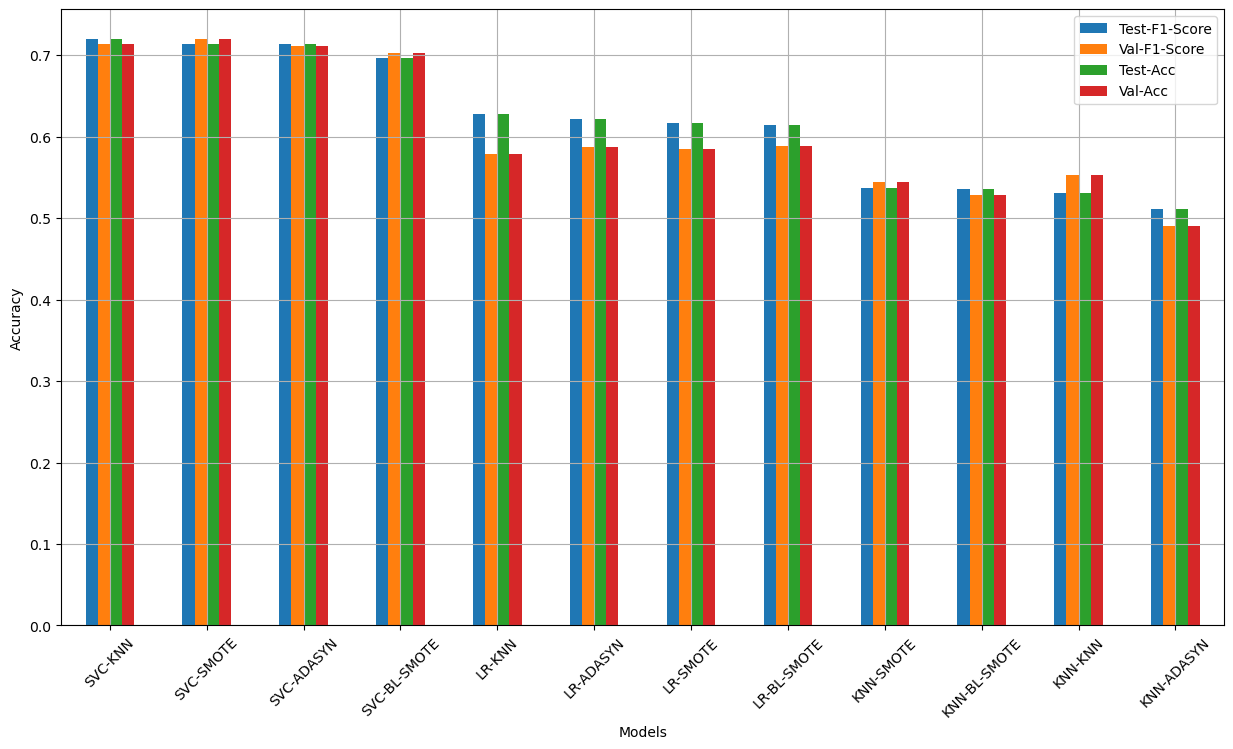

    index         Model  Test-F1-Score  Val-F1-Score  Test-Acc   Val-Acc
0       3       SVC-KNN       0.720430      0.713978  0.720430  0.713978
1       0     SVC-SMOTE       0.713978      0.720430  0.713978  0.720430
2       9    SVC-ADASYN       0.713978      0.711828  0.713978  0.711828
3       6  SVC-BL-SMOTE       0.696774      0.703226  0.696774  0.703226
4       4        LR-KNN       0.627957      0.578495  0.627957  0.578495
5      10     LR-ADASYN       0.621505      0.587097  0.621505  0.587097
6       1      LR-SMOTE       0.617204      0.584946  0.617204  0.584946
7       7   LR-BL-SMOTE       0.615054      0.589247  0.615054  0.589247
8       2     KNN-SMOTE       0.537634      0.544086  0.537634  0.544086
9       8  KNN-BL-SMOTE       0.535484      0.529032  0.535484  0.529032
10      5       KNN-KNN       0.531183      0.552688  0.531183  0.552688
11     11    KNN-ADASYN       0.511828      0.490323  0.511828  0.490323


In [41]:
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)

test_predictions(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)